In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm

In [2]:
ff_factors = pd.read_csv('data/F-F_Research_Data_Factors_Monthly.csv',index_col=0)
ff_factors.index = pd.to_datetime(ff_factors.index)
ff_cov_df = ff_factors.ewm(halflife=36,min_periods=36).cov()
ff_cov_df.to_pickle(f'data/ff_cov_halflife{36}.pkl',protocol=4)

In [3]:
spec_df = pd.read_pickle('data/specific_returns_halflife36_TOP2000.pkl')
spec_est = spec_df.ewm(halflife=36,min_periods=36).var()[spec_df.notna()]
spec_est = spec_est.stack()
spec_est.to_pickle(f'data/spec_est_halflife{36}_TOP{2000}.pkl',protocol=4)


Function to compute risk model covariance matrix

In [4]:
universe = pd.read_csv(f'data/TOP2000_universe.csv',parse_dates=[0],index_col=0)
ff_loadings = pd.read_pickle('data/ffloadings_halflife36_TOP2000.pkl')
ff_cov_df = pd.read_pickle(f'data/ff_cov_halflife{36}.pkl')
spec_est = pd.read_pickle(f'data/spec_est_halflife{36}_TOP{2000}.pkl')

def risk_cov(date):
    ff_cols = ['Mkt-RF','HML','SMB']
    betas = ff_loadings.loc[date,(universe.loc[date],slice(None))].unstack()[ff_cols].dropna(axis=0)
    ff_cov = ff_cov_df.loc[date].loc[ff_cols,ff_cols]
    spec_cov = spec_est.loc[date]
    
    idx = spec_cov.index.intersection(betas.index)
    spec_cov = spec_cov.reindex(idx)
    betas = betas.reindex(idx)

    cov = betas@ff_cov@betas.T + np.diag(spec_cov)
    return cov

In [5]:
risk_cov(ff_loadings.index[300])

permno,10060,10065,10071,10078,10104,10107,10108,10114,10119,10126,...,89712,89982,90100,90369,90537,90609,90879,91380,92284,92655
permno,,,,,,,,,,,,,,,,,,,,,
10060,0.019621,-0.000337,-0.000716,-0.000003,0.000444,-0.000587,0.000520,0.000459,-0.000658,-0.000196,...,0.000714,-0.000299,-0.000286,-0.000748,0.000302,-0.001066,-0.000698,-0.000494,-0.000124,-0.000549
10065,-0.000337,0.001285,0.002246,0.001251,0.001640,0.001151,0.000648,0.002182,0.001450,0.000549,...,0.000504,0.000443,0.000924,0.001205,0.000269,0.001546,0.002397,0.001566,0.002011,0.001561
10071,-0.000716,0.002246,0.016852,0.006455,0.007883,0.005320,0.003334,0.010766,0.005745,0.002054,...,0.002758,0.001737,0.003710,0.004808,0.001447,0.006742,0.011091,0.007181,0.008970,0.007209
10078,-0.000003,0.001251,0.006455,0.015518,0.005420,0.003899,0.002352,0.007784,0.003143,0.000942,...,0.001961,0.000982,0.002021,0.002783,0.001044,0.004661,0.007862,0.005041,0.005749,0.005146
10104,0.000444,0.001640,0.007883,0.005420,0.020484,0.003747,0.003721,0.010097,0.004531,0.001767,...,0.003494,0.001205,0.003139,0.003422,0.001717,0.004403,0.008729,0.005613,0.008014,0.005512
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90609,-0.001066,0.001546,0.006742,0.004661,0.004403,0.004259,0.001516,0.006538,0.003655,0.001094,...,0.000927,0.001255,0.002185,0.003436,0.000587,0.019014,0.008002,0.005186,0.005386,0.005349
90879,-0.000698,0.002397,0.011091,0.007862,0.008729,0.006415,0.003625,0.012304,0.006011,0.001978,...,0.002911,0.001881,0.003825,0.005233,0.001566,0.008002,0.032785,0.008361,0.009793,0.008486
91380,-0.000494,0.001566,0.007181,0.005041,0.005613,0.004142,0.002319,0.007901,0.003924,0.001298,...,0.001854,0.001229,0.002494,0.003414,0.000999,0.005186,0.008361,0.015294,0.006331,0.005477


In [6]:
all(np.linalg.eig(risk_cov(ff_loadings.index[100]))[0] > 0)

True

Risk Model R2

In [7]:
spec_df = pd.read_pickle('data/specific_returns_halflife36_TOP2000.pkl').stack()
spec_df.index = spec_df.index.set_names('date',level=0)
sys_df = pd.read_pickle('data/systematic_returns_halflife36_TOP2000.pkl').stack()
sys_df.index = sys_df.index.set_names('date',level=0)
spec_df,sys_df = spec_df.align(sys_df,join='inner')

ret_df = spec_df + sys_df




<AxesSubplot:ylabel='Count'>

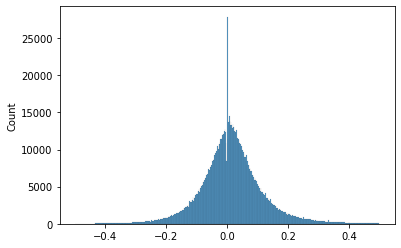

In [8]:
sns.histplot(ret_df,binrange=(-0.5,0.5))

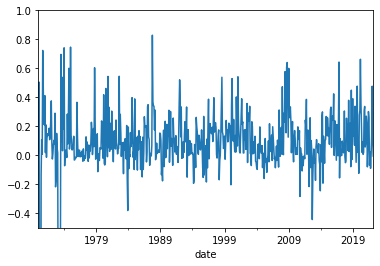

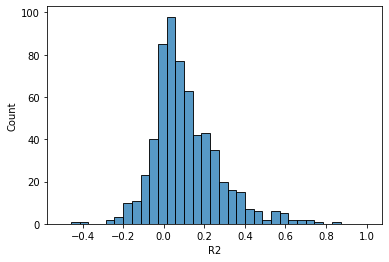

Mean R2: 0.04879196707971851
Median R2: 0.07496424285312475
T-test: Ttest_1sampResult(statistic=1.4815308307058181, pvalue=0.06948416988641007)


In [9]:
from scipy.stats import ttest_1samp

r2_df = 1 - spec_df.clip(-0.5,0.5).groupby('date').var()/ret_df.clip(-0.5,0.5).groupby('date').var()
r2_df.plot(ylim=(-0.5,1))
plt.show()
sns.histplot(r2_df,binrange=(-0.5,1))
plt.xlabel("R2")
plt.show()

print("Mean R2:", r2_df.mean())
print("Median R2:", r2_df.median())
print("T-test:", ttest_1samp(r2_df,0,alternative='greater'))

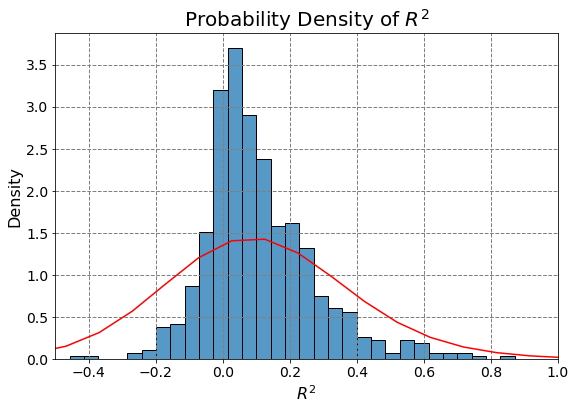

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(9, 6))
sns.histplot(r2_df,binrange=(-0.5,1), ax=ax, stat='density')
ax.grid(ls='--', lw=1, color='gray')
sns.kdeplot(r2_df, color='red', ax=ax)
ax.set_xlim((-0.5, 1))
ax.set_xlabel('$R^2$', size=16)
ax.set_ylabel('Density', size=16)
ax.set_title('Probability Density of $R^2$', size=20)
ax.tick_params('both', labelsize=14)